# 12. 인공지능으로 세상에 없던 새로운 패션 만들기

## 1. 들어가며

### 학습 전제
---
* Convolution의 padding, stride 등의 기본 개념을 알고 있다.
* 교차 엔트로피(Cross Entropy) 등의 손실 함수, 최적화 함수 등 딥러닝의 기본적인 학습 알고리즘을 알고 있다.
* 텐서플로우를 활용해 신경망을 학습시키는 코드를 다뤄본 적이 있다.
* 간단한 판별 모델링(분류, 회귀 등)의 개념을 알고, 실습해 본 적이 있다.

### 학습 목표
---
* 생성 모델링 개념을 이해하며 판별 모델링과의 차이 알기
* Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기
* Fashion MNIST 데이터셋의 의미를 알기
* 생성적 적대 신경망(GAN)의 구조와 원리를 이해하기
* 텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하기

### 목차
---
* 없던 데이터를 만들어낸다, 생성 모델링
* 여러 가지 생성 모델링 기법과 친해지기
* 패션을 디자인하려면? 먼저 패션을 배워야지!
* 그림을 만들어내는 화가 생성자(Generator), 그리고 평가하는 비평가 구분자(Discriminator)
* 생성 모델이 똑똑해지기 위한 기나긴 여정

## 2. 없던 데이터를 만들어낸다, 생성 모델링
오늘은 __생성 모델링 (Generative Modeling)__ 이라는, 지금까지 배웠던 것들과는 조금 색다른 주제를 학습할 것이다.<br>
생성 모델링을 직접 다뤄보기 전에, 생성 모델링은 무엇이고 어떤 것을 목표로 하는 것인지, 그리고 주요 생성 모델링 기법에는 무엇이 있는지 알아보자.

__생성 모델링__은 지금까지 접해 보았던 기본적인 딥러닝 모델들과는 사뭇 다르다.

무엇이 다른 걸까? 이전에 배웠던 여러 이미지 또는 자연어 처리 모델을 떠올려보자. [`인공지능과 가위바위보 하기 프로젝트`](https://github.com/IsaacTips/AIFFEL/blob/master/Exploration/E1_Rock_Scissors_Paper/%5BE1%5Drock_scissor_paper.ipynb)에서는 직접 가위, 바위, 보에 해당하는 사진을 찍어 데이터셋을 만들고, 각 이미지를 알맞은 카테고리로 __분류__ 할 수 있도록 학습시켰다. 이러한 모델을 우리는 __판별 모델링 (Discriminative Modeling)__ 이라고 부른다. 말 그대로 입력받은 데이터를 어떤 기준에 대해 판별하는 것이 목표인 모델링이다.

반면, __생성 모델링__은 말 그대로 없던 데이터를 __생성__해내는 것이 목표이다. 가위바위보 프로젝트로 대입해 본다면 다양한 가위, 바위, 보가 담긴 데이터셋에서 각 이미지의 특징을 학습해 그와 비슷한 새로운 사진을 만들어내야 하는 것이다. 물론 우리는 실제 사진과 거의 구별이 어려울 정도로 좋은 품질의 이미지를 만들어내는 것이 최종 목표이다.

즉, 판별 모델과 생성 모델을 한 마디로 설명한다면,

* __판별 모델__ : 입력된 데이터셋을 특정 기준에 따라 분류하거나, 특정 값을 맞추는 모델
* __생성 모델__ : 학습한 데이터셋과 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성하는 모델
로 정리할 수 있다.


새로운 무언가를 만들어 내는 생성 모델링의 아이디어는 꽤나 매력적이다. 하지만 그만큼 어려운 분야이기도 하다. 생성 모델의 개념은 꽤 오래전부터 있었지만 그 성능을 높여 유의미한 결과를 만들어 내는 것은 오랫동안 도전 과제로 남아 있었는데, 최근 여러 분야에서 높은 성능을 보이는 딥러닝 기술과 만나면서 여러 가지 놀라운 결과들을 만들어내고 있다.

본격적으로 생성 모델링에 대해 배우기 전에, 실제로 최근의 생성 모델은 어떤 것을 만들어낼 수 있는지 AWS의 DeepComposer 시연 영상을 보자.


[![DeepComposer](http://img.youtube.com/vi/XH2EbK9dQlg/0.jpg)](https://youtu.be/XH2EbK9dQlg)

## 3. 여러 가지 생성 모델링 기법과 친해지기 (1) Pix2Pix
음악을 생성하는 DeepComposer 외에도 지금까지 연구된 생성 모델에는 간단한 모델에서부터 아주 복잡한 모델까지 매우 다양하다.

방금 봤던 DeepComposer처럼 생성 모델에는 재미있는 기술들이 많다. 오늘은 이미지를 다루는 학습을 할 예정이므로 이미지와 관련된 응용 생성 모델 기법들만 살짝 살펴보고 가자.

### 그림을 사진으로 변환해 보자: Pix2Pix
---
Pix2Pix는 간단한 이미지를 입력할 경우 실제 사진처럼 보이도록 바꿔줄 때 많이 사용되는 모델이다.

모델은 아래 그림처럼 단순화된 __이미지(Input Image)__ 와 __실제 이미지(Ground Truth)__ 가 쌍을 이루는 데이터셋으로 학습을 진행한다.<br>
왼쪽의 Input Image를 입력받으면, 내부 연산을 통해 실제 사진같은 형상으로 변환된 Predicted Image를 출력하는 것이다. 학습 초기에는 모델이 생성한 Predicted Image가 Ground Truth 이미지와 많이 다르겠지만, 계속해서 Ground Truth와 얼마나 비슷한지를 평가하며 점차 실제 같은 결과물을 만들어 내게 된다. 이렇게 한 이미지를 다른 이미지로 픽셀 단위로 변환한다는 뜻의 `Pixel to Pixel`을 딴 `Pix2Pix`로 이름이 붙게 되었다.

<img src="./image/pix2pix.png" alt="pix2pix" />

위의 예시를 보면 Input Image는 매우 단순화된 이미지이기 때문에 건물의 형태나 창문의 위치 등의 구조적인 정보는 알 수 있지만, 실제 세부적인 디자인이 어떻게 되어 있을지는 사람이라도 정확히 맞추기가 어렵다. 그래서 Predicted Image에는 구조적인 정보를 바탕으로 건물 이미지를 만들며 그에 어울리는 세부 디자인을 생성하게 된다. 그 결과물은 Ground Truth와 완벽하게 똑같지는 않지만, 전체적인 분위기는 비슷한 느낌을 받는다.

이러한 Pix2Pix 기법이 응용될 수 있는 다른 사례들은 다음 논문에서 그림으로 확인해 볼 수 있다.

__논문__ : [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf)

## 4. 여러 가지 생성 모델링 기법과 친해지기 (2) CycleGAN

### 모네의 그림을 사진으로, 사진을 다시 모네의 그림으로: CycleGAN
---
Pix2Pix 이후 발전된 모델로는 __CycleGAN__ 이 있다. 이름에서도 느껴지듯 이 모델은 한 이미지와 다른 이미지를 번갈아 가며 Cyclic하게 변환시킬 수 있다. (아래 이미지 참조)

언뜻 생각해 보면 그림을 사진으로 바꾸는 Pix2Pix와 비슷해 보이지만, 한 방향으로의 변환만 가능한 Pix2Pix와 달리 CycleGAN은 양방향으로의 이미지 변환이 가능하다. 즉, 실사 이미지를 그림으로 바꾸는 것과 그림을 실사 이미지로 바꾸는 것 두 가지가 모두 가능한 것이다.

또한 그림과 사진의 쌍으로 이루어진 데이터셋이 필요했던 Pix2Pix와 달리, CycleGAN은 쌍이 필요 없다. 다음과 같이 얼룩말을 그냥 말로, 말을 얼룩말로 서로 변환할 경우 쌍을 이루지 않더라도 그냥 얼룩말이 있는 사진과 말이 있는 사진 각각의 데이터셋만 있다면 CycleGAN을 학습시킬 수 있다. 모델이 스스로 얼룩말과 말 데이터에서 각각의 스타일을 학습해서 새로운 이미지에 그 스타일을 입힐 수 있도록 설계되었기 때문이다. 딥러닝에서 쌍으로 된 데이터(paired data)가 필요 없다는 것은 데이터를 구하기 훨씬 쉽고, 라벨을 붙이는 주석(annotation) 비용이 필요 없다는 것을 뜻하니, 굉장히 큰 장점이라고 할 수 있을 것이다.

<img src="./image/CycleGAN.png" alt="CycleGAN" />

CycleGAN의 또 다른 유명한 활용 사례는 바로 실제 사진을 모네 또는 고흐 같은 화가가 그린 그림처럼 바꾸는 것이다.<br>
다음과 같이 하나의 사진만으로도 모네가 그린 그림, 고흐가 그린 그림 등으로 마음대로 변환 시켜 볼 수 있다.

물론 CycleGAN이기 때문에 그림을 사진처럼 변환시키는 반대의 경우도 가능하다.

<img src="./image/CycleGAN2.jpg" alt="CycleGAN" />

## 5. 여러 가지 생성 모델링 기법과 친해지기 (3) Neural Style Transfer

### 사진에 내가 원하는 스타일을 입혀보자: Neural Style Transfer
---
아주 흥미로운 기법 한 가지만 더 보고 프로젝트를 시작해보자. 바로 스타일을 변환시키는 __Neural Style Transfer__ 이다.

Style Transfer 라는 이름에서 알 수 있듯, 이 기법은 이미지의 스타일을 변환시킨다. 전체 이미지의 구성을 유지하고 싶은 Base Image와 입히고 싶은 스타일이 담긴 Style Image 두 장을 활용해 새로운 이미지를 만들어 내는 것이다. `Neural`은 신경망, 즉 딥러닝 기술을 사용했다는 뜻을 가지고 있다.

<img src="./image/nst.png" alt="Neural Style Transfer" />

여섯 개의 이미지 중 왼쪽 맨 위의 이미지가 Base Image이고, 나머지 다섯 개의 이미지에 작게 붙어있는 이미지가 Style Image이다. 이미지 B~F에 나타난 결과를 보면 Base Image의 건물, 강, 하늘과 같은 내용은 유지하면서, Style Image의 스타일이 잘 입혀진 것을 확인할 수 있다. 즉, Base Image에서는 Content(내용)만, 그리고 Style Image에서는 Style(스타일)만 추출해서 합친 결과물이다.

실제로 이러한 결과를 만들어내는 과정 속에는 다양한 최적화가 포함되어 있다. Base Image의 내용은 잃지 않으면서, Style Image의 스타일을 효과적으로 입히기 위한 정교한 손실함수들이 짜여져 있다.

## 6. 패션을 디자인하려면? 먼저 패션을 배워야지! (1)

### Fashion MNIST
---
지금까지 생성 모델링 분야에서 어떤 응용 기술들이 연구되었는지 살펴보았다.

이제 첫 번째 생성 모델을 직접 구현해 보도록 하자.

패션을 디자인한다는 것은 무엇일까?

사람의 경우를 생각해보자. 멋있는 패션을 자유자재로 디자인하는 패션 디자이너가 되려면, 먼저 다양한 패션을 많이 접하며 좋은 패션이란 무엇인지 학습해야 할 것이다. 그 후 학습한 것들을 토대로 나만의 디자인을 완성해나갈 수 있다.

생성 모델도 같다. 먼저 여러 패션을 접하며 옷, 신발 또는 드레스와 같은 것이 어떻게 생겼는지 학습한 후 새로운 디자인을 만들어내야 한다.

따라서 모델이 학습할 데이터셋을 먼저 준비해보자.<br>
오늘 사용할 데이터셋은 __Fashion MNIST__ 이다. 이름이 익숙하다. 그렇다, 바로 손글씨 숫자 데이터인 MNIST와 아주 비슷한 형태의 데이터셋이다. 신경망 모델 연구 과정에서 MNIST 숫자 데이터가 아주 많이 활용되면서 몇 가지 이유로 Fashion MNIST라는 데이터셋이 새롭게 구축되었는데, 세부 내용은 다음 글에서 한번 확인해보자.

__읽고 오기__ : [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

* Fashion MNIST 데이터셋의 이미지 크기(WXH): 28x28
* Fashion MNIST 데이터셋 구성 : 70,000장 (training set 60,000장 / test set 10,000장)
* Fashion MNIST가 만들어진 이유 세 가지 : 
    - MNIST is too easy. (MNIST는 너무 쉽다.)
    - MNIST is overused. (MNIST는 너무 많이 쓰였다.)
    - MNIST can not represent modern CV tasks. (MNIST는 요즘의 Computer Vision 문제에 적용될 수 없다.)
    
*  Fashion MNIST 카테고리 : 10가지 패션 카테고리가 0~9의 숫자 Label로 표시되었다.
    - 0:    T-shirt/top
    - 1:    Trouser
    - 2:    Pullover
    - 3:    Dress
    - 4:    Coat
    - 5:    Sandal
    - 6:    Shirt
    - 7:    Sneaker
    - 8:    Bag
    - 9:    Ankle boot

## 7. 패션을 디자인하려면? 먼저 패션을 배워야지! (2) 코드로 살펴보기
앞으로 프로젝트를 진행하는 데에 필요한 모든 패키지를 불러오고 시작하도록 하자.<br>
신경망 구성에 필요한 텐서플로우를 포함해서, 이미지와 GIF를 다루는 데 쓰이는 imageio, display, matplotlib, PIL 등 여러 가지 패키지가 필요하다.

imageio, pillow 라이브러리가 없을 경우 설치.

```bash
$ pip install imageio
$ pip install Pillow
```

그리고 다음과 같이 작업환경을 구성.

```bash
$ mkdir -p ~/aiffel/dcgan_newimage/fashion/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/fashion/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/fashion/training_history
```

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


`fashion_mnist` 데이터는 인터넷에서 따로 다운받을 필요 없이, `tf.keras` 안에 있는 `datasets`에 이미 들어가 있어서 꺼내기만 하면 된다.

꺼내서 `load_data()`로 데이터를 로딩해 볼 텐데, 특히 이번에는 분류 문제에서와 달리, 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없다. 즉, MNIST 데이터로 분류 문제를 풀었을 때 필요했던 `y_train`, `y_test`에 해당하는 데이터를 쓰지 않는 다는 말이다. 그렇기 때문에 코드에서 `_` (언더스코어)로 해당 데이터들은 무시하도록 하자.

* 참고: [파이썬 언더스코어(_)에 대하여](https://mingrammer.com/underscore-in-python/#2-%EA%B0%92%EC%9D%84-%EB%AC%B4%EC%8B%9C%ED%95%98%EA%B3%A0-%EC%8B%B6%EC%9D%80-%EA%B2%BD%EC%9A%B0)

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

Fashion MNIST 또한 MNIST와 같이 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가진다.

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠준다.

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


데이터셋의 shape는 어떨까?

In [6]:
train_x.shape

(60000, 28, 28)

앞서 읽었던 공식 문서에서 확인했듯이, train 데이터셋에는 6만 장의 이미지가 들어있다. 또, 이미지의 사이즈는 28x28임을 확인할 수 있다.

다만 여기서 한 가지 추가되어야 할 것이 있다. <br>
앞서 CNN(합성곱) 계층을 다룰 때 배웠듯, 딥러닝에서 이미지를 다루려면 __채널 수__에 대한 차원이 필요하다. 입력되는 이미지 데이터의 채널 수는 어떤 이미지냐에 따라 달라지는데, 컬러 이미지의 경우 R, G, B 세 개의 채널이 있고, Gray Scale(흑백)의 경우 1개의 채널만 존재한다. Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이다. 따라서 데이터셋의 shape 마지막에 1을 추가해 주도록 하자.

In [7]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

마지막에 1의 채널이 잘 추가되었다.

한번 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인해보자.

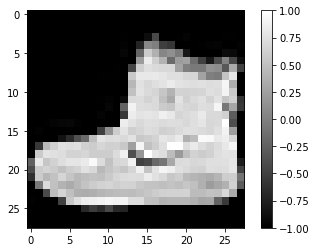

In [8]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

첫 번째, 즉 index `0`의 이미지는 바로 신발이었다.<br>
`plt.colorbar()` 를 이용해 오른쪽에 각 픽셀의 값과 그에 따른 색도 확인해 보았다. 픽셀에는 우리가 정규화 해준 대로 -1 ~ 1 사이의 값을 가지고, -1이 가장 어두운 검은색, 1이 가장 밝은 흰색을 띤다고 표시되어 있다.

하나만 보면 아쉬우니, 열 개 정도를 한 번에 띄워보자.

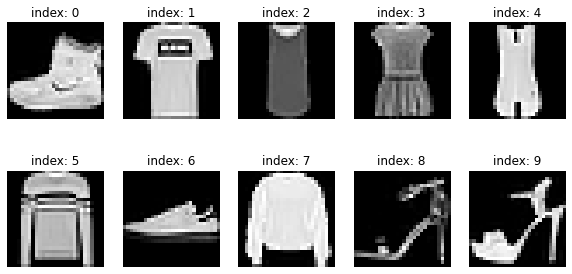

In [9]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

맨 첫 줄의 `plt.figure(figsize=(10, 5))`는 이미지의 전체 프레임의 크기를 결정한다.

또한 여러 개의 이미지를 한 번에 띄우고 싶을 때에는 `plt.subplot(row, col, index)`의 형태로 볼 수 있다.<br>
10개의 이미지를 2x5의 배열 형태로 보고 싶은 경우, `plt.subplot(2, 5, index)`로 작성하면 되는 것이다. index는 1부터 10까지 순서대로 바뀌어야 하니 for문에서 사용하는 `i`에 `1`을 `i+1`을 넣어주면 된다. (`i`는 `range(10)`으로 꺼냈으니 0~9의 숫자로 반복된다)

추가적으로 `plt.title('title')` 함수를 이용해서 이미지에 제목으로 라벨값을 넣어줬고, `plt.axis('off')` 함수로 불필요한 축을 지워서 깔끔하게 나타냈다.

이번에는 for 문을 활용해서 이미지 25개를 5x5 의 배열로 띄워보자.

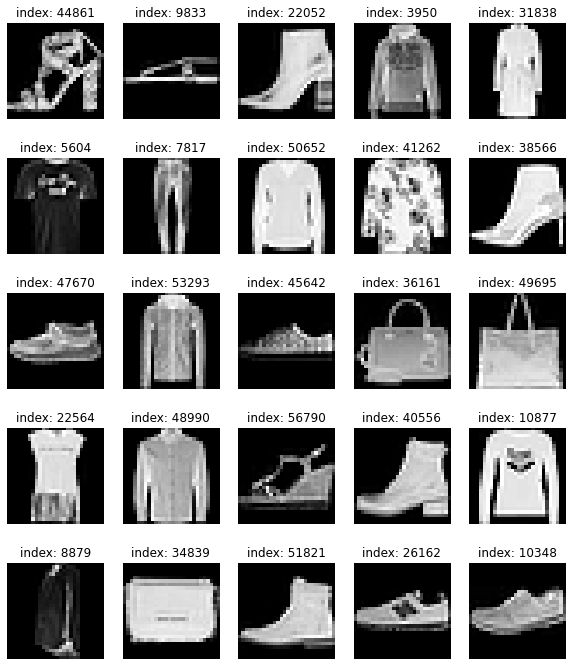

In [10]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

이렇게 정리된 데이터를 곧 모델에 넣어서 학습시켜야 하니, 편하게 사용할 수 있도록 텐서플로우의 `Dataset`을 이용해 준비해 놓도록 하자. 이를 이용하면 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 된다.

In [11]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

`BUFFER_SIZE`은 전체 데이터를 섞기 위해 60,000으로 설정한다. `shuffle()` 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것이다.

* 참고: [텐서플로우 공식 문서: tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)

`BATCH_SIZE`는 모델이 한 번에 학습할 데이터의 양이다.<br>
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행한다. 이러한 방식을 __미니배치 학습__이라고 한다.

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 `from_tensor_slices()` 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다. 위 코드는 `train_x`라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.

## 8. 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (1) GAN 이해하기

### GAN이란
---
자, 이제 데이터가 준비되었으니 모델을 만들어 볼 차례이다. 이번에 만들 모델은 어떻게 생겼을까?

위에서 많은 생성 모델들이 무엇을 할 수 있는지 먼저 살펴보았다. 하지만 그것들은 모두 꽤나 발전된 형태의 생성 모델링 기법들이다. 아직 첫 번째 생성 모델을 만드는 것이니 간단한 것부터 시작해 보도록 하자.

가장 간단한 형태의 생성 모델 중 하나는 바로 GAN(Generative Adversarial Network)이다. GAN은 2014년 Ian Goodfellow라는 연구자에 의해 처음 나온 네트워크로, 발표된 후 독특하면서도 직관적인 아이디어로 많은 인기를 얻었고 지금까지도 굉장히 많은 연구가 이루어지고 있는 모델이다.

맨 처음 DeepComposer 영상에서도 설명했듯, GAN에는 두 가지 네트워크가 있다.

* `생성자(Generator)`는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해낸다. 즉, 무에서 유를 창조하는 것과 같은 역할을 한다.
* `판별자(Discriminator)`는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지, Fake인지에 대한 판단 정도를 실숫값으로 출력한다.
Ian Goodfellow가 GAN을 처음 발표했던 2014년의 논문에서는 이 두 네트워크를 다음과 같이 비유했다. 원문을 한번 보자.

>_"In the proposed adversarial nets framework, the generative model is pitted against an adversary: a discriminative model that learns to determine whether a sample is from the model distribution or the data distribution. The generative model can be thought of as analogous to a team of counterfeiters, trying to produce fake currency and use it without detection, while the discriminative model is analogous to the police, trying to detect the counterfeit currency. Competition in this game drives both teams to improve their methods until the counterfeits are indistiguishable from the genuine articles." (출처 : https://arxiv.org/pdf/1406.2661.pdf)_

* Generative Model과 Discriminative Model 비유
    - Generative Model : 위조지폐를 만들어내는 팀
    - Discriminative Model : 위조 지폐범을 잡아내는 경찰
* 두 팀을 모두 성장하게 하는 요인, 궁극적인 목표
    - 위조지폐를 만들어내는 팀은 잡히지 않기 위해 더 진짜 같은 지폐를 만들려고 하며, 그것을 잡아내려는 경찰은 끊임없이 진짜 지폐와 위조지폐를 구분하려고 한다. 즉, 서로 간의 경쟁이 둘 모두를 성장하게 한다. 궁극적인 목표는 진짜 지폐와 구분될 수 없는 위조지폐를 만들어 내는 것이다.
    
이렇게 서로 경쟁하듯 이루어진 모델의 구조 덕분에 이름에 "Adversarial(적대적인)"이 들어가게 된 것이다.

<img src="./image/gan.png" alt="GAN" />

### GAN과 생성 모델 다시 정리하기
---
추가로 GAN에 대한 여러 가지 설명이 잘 나와 있는 2016년의 OpenAI 글을 한번 읽어보자.

__읽기__ : [https://openai.com/blog/generative-models/](https://openai.com/blog/generative-models/)

* GAN 중 특히 합성곱 층(Convolutional Layer)으로 이루어진 딥러닝 모델을 DCGAN (Deep Convolutional GAN) 이라고 한다. DCGAN은 무엇을 입력받아 무엇을 출력할까?
    - Input : 100 random numbers drawn from a uniform distribution (called as a code, or latent variables)
    - Output : an image (in this case 64x64x3 images)
* 글에서 소개한 3가지 생성모델링 기법
    - GAN(Generative Adversarial Network)
    - Variational Autoencoders (VAEs)
    - Autoregressive models (ex. Pixel RNN)

## 9. 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (2) 생성자 구현하기
GAN의 모델 구조를 알아보았으니, 바로 코드로 모델을 어떻게 구현할 수 있는지 확인해보자.

> _GAN에는 생성자, 판별자 모델 두 개가 있습니다._

오늘 구현해 볼 모델은 이전 스텝에서 언급했던 `DCGAN(Deep Convolutional GAN)`이다. DCGAN은 GAN의 개념이 처음 소개된 1년 반 이후 발표된 논문으로서, 이전의 GAN을 더욱 발전시켜서 훨씬 그럴듯한 고화질 이미지 생성을 이루어낸 첫 번째 논문으로 평가받고 있다. 이후 발표된 수많은 GAN 기반 이미지 생성모델들은 대부분 DCGAN 모델을 발전시킨 형태라고 할 수 있으므로, 그 구조를 상세히 살펴보고 구현 연습을 해보는 것은 매우 의미 있다고 생각된다.

모델의 구현은 Keras `Sequential` API를 활용하겠다. 이후 소개하는 코드는 [Tensorflow 2.0 Tutorial의 DCGAN 구현](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)을 기반으로 상세한 설명을 추가하였다.

* 참고: [러닝 텐서플로- Chap07.3 - 텐서플로 추상화와 간소화, Keras](https://excelsior-cjh.tistory.com/159)


In [13]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

`make_generator_model`이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 했다.

함수 내부에서는 먼저 `tf.keras.Sequential()`로 모델을 시작한 후 레이어를 차곡차곡 쌓아준다.

여기에서 가장 중요한 레이어는 바로 `Conv2DTranspose` 레이어이다. `Conv2DTranspose` 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다. 이 모델에서는 세 번의 `Conv2DTranspose` 층을 이용해 `(7, 7, 256) → (14, 14, 64) → (28, 28, 1)` 순으로 이미지를 키워나간다. 여기서 최종 사이즈인 `(28, 28, 1)`은 준비했던 데이터셋과 형상이 동일하다.

* 참고: [What is Transposed Convolutional Layer?](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)

레이어의 사이사이에 특정 층들이 반복되는 것을 확인할 수 있는데, `BatchNormalization` 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜준다. 또한 중간층들의 활성화 함수는 모두 `LeakyReLU`를 사용하였다. 다만 마지막 층에는 활성화 함수로 `tanh`를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함이다.

* 참고: [라온피플-Batch Normalization](https://m.blog.naver.com/laonple/220808903260)
* 참고: [활성화 함수 (activation function)](https://newly0513.tistory.com/20)

모델 구조를 한번 자세히 살펴보자.

* 생성자의 입력 벡터 형태 : 모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받는다.
* 입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 된다.
* 첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 된다.
    - 이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업이다.

그럼 생성 모델을 `generator`라는 변수로 생성하고, 모델 세부 내용인 `summary`를 출력해보자.

In [14]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

그럼 모델이 만들어졌으니, `shape=(1, 100)`의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보도록 하자.<br>
아직 모델이 학습되지 않았으니, 아마 결과물도 큰 의미가 있지는 않을 것이다.

`tf.random.normal`을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.



In [15]:
noise = tf.random.normal([1, 100])

텐서플로우 2.0 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성된다. (내부적으로는 생성자의 __call__ 함수가 호출된다)

단, 지금은 학습하는 중이 아니니 `training=False`를 설정해 주어야한다 Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 `training=False`을 주어야 올바른 결과를 얻을 수 있다.

In [16]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

`[1, 28, 28, 1]` 사이즈의 이미지가 잘 생성되었다.<br>
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (28, 28, 1) 사이즈 이미지가 생성되었다는 뜻을 가진다.

그러면 이 이미지를 또 시각화해서 봐야겠다.<br>
`matplotlib` 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 `(28, 28)` shape의 이미지를 꺼낼 수 있도록 해야한다.

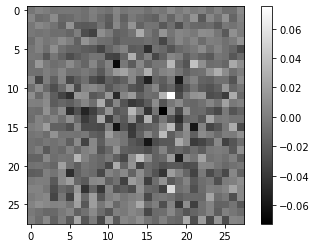

In [17]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

역시 -1과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있다.<br>
아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성되었지만, 모델이 점차 학습해 나가며 제대로 된 이미지를 생성할 수 있을 것이다.

## 10. 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (3) 판별자 구현하기
판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야한다.<br>
그렇다면 입력은 (28, 28, 1) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것이다.



In [18]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

판별자 또한 `make_discriminator_model` 함수로 구현하였다.

`Conv2DTranspose` 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 `Conv2D` 층으로 이미지의 크기를 점점 줄여나간다. <br>
첫 번째 Conv2D 층에서 입력된 `[28, 28, 1]` 사이즈의 이미지는 다음 층을 거치며 `(28, 28, 1) → (14, 14, 64) → (7, 7, 128)`까지 줄어들게 된다.

마지막에는 `Flatten` 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환한다. 이는 생성자의 `Reshape` 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 한다. 1차원 벡터로 변환한 후에는 마지막 `Dense` Layer를 거쳐 단 하나의 값을 출력하게 된다.

그럼 판별 모델을 `discriminator`라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력해보자.

In [19]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

그렇다면 아까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올까? 바로 확인해보자.

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00178849]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 되었다. 이 값 또한 아직까진 아무런 의미가 없는 값이다.

그렇다면 이제 드디어 모델 학습을 위한 여정을 떠나보자.

## 11. 생성 모델이 똑똑해지기 위한 기나긴 여정 (1) 손실함수와 최적화 함수
이제 생성자와 판별자 두 가지 네트워크가 모두 준비되었으니 모델을 학습시키는 일만 남았다.<br>
생성자가 판별자를 속이기 위해 학습해 나가면서 결국 잘 학습되면 어떤 새로운 패션을 만들어낼지 기대가 된다.

자, 그러면 모델 학습을 위한 재료를 준비해보자.<br>
딥러닝 모델이 학습하기 위해서 꼭 필요한 두 가지는, 바로 손실함수(loss function)와 최적화 함수(optimizer)이다.

### 손실함수(loss function)
---
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.<br>
교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이다. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰인다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것이다.

자, 이쯤에서 다시 생성자와 판별자의 목적이 무엇이었는지 한번 정리해보자. 생성자는 자기가 생성한 Fake Image를 판별자가 진짜라고 판단하도록 속이고 싶어한다. 판별자는 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것이 목표이다.

그렇다면 Real Image에 대한 라벨을 `1`, Fake Image에 대한 라벨을 `0`으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같을 것이다.

* 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 `D(fake_image)` 값이 `1`에 가까워지는 것
* 판별자 : Real Image 판별값, 즉 `D(real_image)`는 `1`에, Fake Image 판별값, 즉 `D(fake_image)`는 `0`에 가까워지는 것

결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되는 것이다. 이러한 기준을 가지고 생성자, 판별자 각각에 대한 손실함수를 설계해보자.

손실함수에 사용할 교차 엔트로피 함수는 `tf.keras.losses` 라이브러리 안에 있다.

다만, 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있는 것이다.

그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정한다 ([참고](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy#args_1)). 따라서 `from_logits`를 `True`로 설정해 주어야 `BinaryCrossEntropy`에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

그럼, 이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.

* `fake_output` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 `D(fake_image)`
* `real_output` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 `D(real_image)`

그럼 이제, `fake_output`과 `real_output`을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까?

바로 `tf.ones_like()`와 `tf.zeros_like()` 함수를 활용하면 된다.<br>
이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용한다.<br>
어떤 식으로 활용되는지, 한번 보자.

In [22]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

입력해 준 `vector`와 형태는 같지만, 그 내용물은 모두 1인 벡터가 만들어졌다. 간단히 원하는 영벡터 또는 1로 채워진 벡터를 만들어낼 수 있는 것이다.

#### generator_loss
그러면 `generator_loss`는 다음과 같이 구현할 수 있겠다.

`generator_loss`는 `fake_output`가 1에 가까워지기를 바라므로, 다음과 같이 `tf.ones_like`와의 교차 엔트로피값을 계산하면 된다.<br>
즉, `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.



In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### discriminator_loss

반면, `discriminator_loss`는 `real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산한다. `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교하면 된다.

최종 `discriminator_loss` 값은 이 둘을 더한 값이다.



In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### discriminator accuracy
한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까? 그렇지 않다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.



In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같다.

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

* (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
    - `>> tf.Tensor([False, False, True, True])`
* (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
    - `>> tf.Tensor([0.0, 0.0, 1.0, 1.0])`
* (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
    - `>> 0.5`

### 최적화 함수(optimizer)
---
자.. 그럼 손실함수는 모두 설계가 되었고, 이제 최적화 함수를 설정할 차례이다. 이번에는 __Adam 최적화 기법__ 을 활용해 보자.

* 참고: [문과생도 이해하는 딥러닝 (8) - 신경망 학습 최적화](https://sacko.tistory.com/42)

Adam 함수 또한 `tf.keras.optimizers` 안에 있다.<br>
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천한다.

또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다.

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것이다.

샘플은 한 번에 16장을 생성하도록 하겠다.<br>
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 한다.<br>
즉, 100차원의 노이즈를 총 16개, `(16, 100)` 형상의 벡터를 만들어 두도록 하자.

In [27]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 12. 생성 모델이 똑똑해지기 위한 기나긴 여정 (2) 훈련과정 설계
그렇다면 이제 진짜 훈련을 위한 코드를 만들어 보도록하자.

하나의 미니배치 당 진행할 `train_step` 함수를 먼저 만들어야 한다.<br>
텐서플로우 2.0 이후부터는 1.x의 이전 버전과 다르게, session을 사용하지 않는다. 대신, 학습시킬 훈련 함수 위에 `@tf.function` 이라는 데코레이터를 붙여서 사용한다. 이 데코레이터는 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해준다.

* 참고: [python decorator (데코레이터) 어렵지 않아요](https://bluese05.tistory.com/30)

데코레이터의 개념은 어렵지 않으시더라도 `@tf.function` 이 정확히 어떤 역할을 해주는 것인지 명확히 이해가 안 되실 수도 있을 것 같다.<br> [Tensorflow Tutorial](https://www.tensorflow.org/api_docs/python/tf/function)에는 이 데코레이터의 역할을 다음과 같이 정의하고 있다.

> _tf.function : Compiles a function into a callable TensorFlow graph_

아래 두 코드를 실행해 보면 위 정의의 의미가 명확해질 것이다.

In [31]:
import numpy as np
import tensorflow as tf

def f(x, y):
    print(type(x))
    print(type(y))
    return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [33]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
    print(type(x))
    print(type(y))
    return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

Numpy array 입력 x, y를 동일하게 사용했지만 f(x,y)의 결과 타입은 다르다. `@tf.function` 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환된다. 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있다.

In [34]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

`train_step` 함수를 하나하나 뜯어보면 다음과 같다.

* (1) 입력데이터: Real Image 역할을 할 `images` 한 세트를 입력으로 받음
* (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 `noise`를 `images` 한 세트와 같은 크기인 `BATCH_SIZE` 만큼 생성함
* (3) `tf.GradientTape()`는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 `with` 구문 열기
* (4) generated_images 생성 : generator가 `noise`를 입력받은 후 `generated_images` 생성
* (5) discriminator 판별 : discriminator가 Real Image인 `images`와 Fake Image인 `generated_images`를 각각 입력받은 후 `real_output`, `fake_output` 출력
* (6) loss 계산 : `fake_output`, `real_output`으로 generator와 discriminator 각각의 loss 계산
* (7) accuracy 계산 : `fake_output`, `real_output`으로 discriminator가
* (8) gradient 계산 : `gen_tape`와 `disc_tape`를 활용해 gradient를 자동으로 계산
* (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
* (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

이러한 일련의 과정을 통해 한 번의 `train_step`이 끝나게 된다.

그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 보자.<br>
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다.

In [35]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

model이 16개의 seed가 들어있는 `sample_seeds`를 입력받아서 만들어낸 `prediction`을 matplotlib으로 시각화해주는 과정이 담겨 있는데, 뭔가 익숙하다.

바로 위에서 해봤던, subplot을 이용해서 총 16개의 sample을 시각화하는 과정이다. 16개이므로 4행 4열로 나누어 `subplot(4, 4, i+1)`로 시각화하는 것이다.

또한, `plt`에 저장되어 보여지는 이미지를 `plt.savefig`로 간단히 파일화 해서 저장한다.<br>
다만, 우리가 원하는 것은 `generated_samples`라는 폴더 아래에 저장하는 것이므로 `try` 구문을 이용해 폴더가 없는 상황에 에러가 발생하는 것을 방지한다. 만약 폴더가 없어서 에러가 난다면, except 구문으로 들어가 `os.mkdir('./generated_samples')`로 폴더를 만든 후 파일을 저장할 수 있다.

학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없다. GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문이다. `train_step()` 함수가 리턴하는 `gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy` 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어보자. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정이다.



In [36]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어준다.

`tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다.<br>
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적이다. 아주 오랜 시간동안 학습을 시켰는데 네트워크가 끊긴다거나, 예상치 못한 문제로 인해 모델을 잃어버린다면 그보다 끔찍한 일은 없기 때문이다..

checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장한다. 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장하는 것이다. 게임의 체크포인트처럼 학습 환경과 학습한 내용을 저장해둔다.

checkpoint 모델을 저장하기 위해 작업환경 내에 `training_checkpoints` 라는 디렉토리를 사용하자.

In [37]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 13. 생성 모델이 똑똑해지기 위한 기나긴 여정 (3) 학습 시키기
이제 모델 학습이다.

지금까지 한 단계를 학습하는 `train_step`, 샘플 이미지를 생성하고 저장하기 위한 `generate_and_save_images()`, 학습 과정을 시각화하는 `draw_train_history()`, 그리고 모델까지 저장하기 위한 checkpoint까지 모두 준비가 되었으니 이것들을 한 곳에 합치기만 하면 된다.

한번 확인해보자.

In [38]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

여기서부터는 정말 별로 특별한 것이 없다. 생성된 샘플을 시각화하거나 원하는 시간을 출력하는 것뿐이기 때문이다.<br>
출력하고자 하는 print문과 몇 번마다 출력하는지에 대한 구문을 원하는 대로 수정해서 마음에 드는 형태로 확인할 수 있다

그러면 모델을 저장하는 간격을 담당하는 `save_every`와 전체 학습 에포크를 결정하는 `EPOCHS` 파라미터도 설정해준 후 훈련시켜 보도록 하겠다.

본 학습은 이미지를 활용한 것이기 때문에 CPU 환경에서는 매우 느릴 수 있다.<br>
RTX2070 또는 구글 Colab의 T4 정도 사양의 경우 1 Epoch 당 10초가 걸리는 반면, 일반적인 CPU 환경에서는 최소 3분에서 10분 이상이 걸릴 수 있으므로 최대한 GPU 환경에서 실습해 보는 것을 추천한다.

이제 다음과 같이 `train()` 함수를 실행시키면 드디어 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인할 수 있다.



In [39]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GAN 학습을 드디어 시작한다.

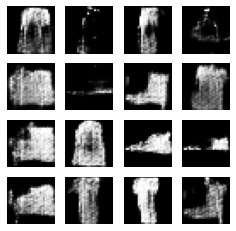

Time for training : 668 sec


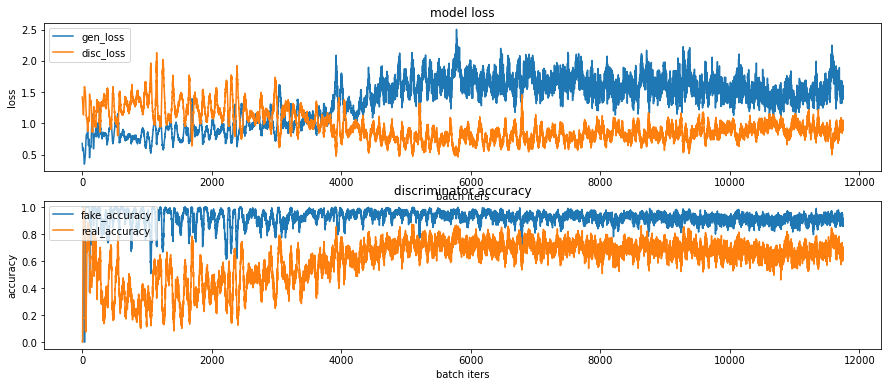

CPU times: user 4min 47s, sys: 13.3 s, total: 5min 1s
Wall time: 11min 9s


In [42]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

학습이 성공적으로 진행되었나?

만약 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻이다.

보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야한다. 결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보자.<br>
과연 생성 모델이 이전에는 없던 새로운 디자인의 패션을 만들어내는 것을 확인할 수 있을 것이다 (물론 시간은 그와 비례하게 늘어날 것이다ㅋㅋㅋ)

어쩌면 단순히 학습수행 시간만 늘리는 것보다, 모델구조나 학습 방법을 바꾸어 봐야 할 수도 있다. 그래프를 유심히 보면서 학습 결과가 더이상 개선되고 있지 않은지 여부를 지속적으로 살펴보자.

### 학습과정 시각화하기
---
학습이 끝난 후 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어 보자. 더욱 생생한 학습 진행 과정을 확인해 볼 수 있을 것이다.

GIF 파일은 우리가 오래전에 import 해놓았던 `imageio` 라이브러리를 활용해 만들 수 있다.<br>
`imageio.get_writer`를 활용해서 파일을 열고, 거기에 `append_data`로 이미지를 하나씩 붙여나가는 방식이다.<br>
아래 코드가 무사히 실행되면, `fasion_mnist_dcgan.gif` 파일이 저장되어 있는 것을 확인할 수 있다!

In [44]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel-dj10 aiffel-dj10 1301472  2월 23 15:47 /home/aiffel-dj10/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


어떤가? 생성자가 만들어내는 이미지의 품질이 점점 개선되어 가는 과정을 한눈에 볼 수 있다.

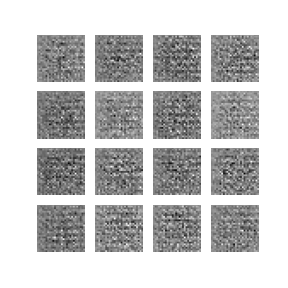


이상으로 세상에 없는 새로운 패션 만들기의 과정 전체를 살펴보았다.